# 分类问题

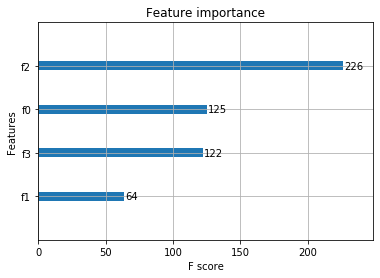

0.9473684210526315


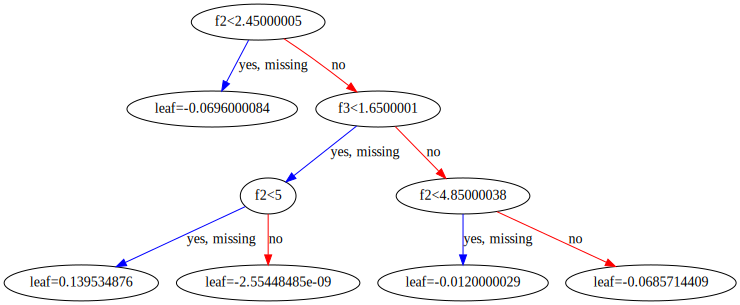

In [109]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd

X,y = load_iris(return_X_y=True) # iris 花
x_train, x_test, y_train, y_test = train_test_split(X, y)


model = XGBClassifier(learning_rate=0.1,
                      n_estimators=100,          # 树的个数--100棵树建立xgboost
                      max_depth=6,               # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      colsample_btree=0.8,       # 随机选择80%特征建立决策树
                      objective='multi:softmax', # 指定损失函数
                      scale_pos_weight=1         # 解决样本个数不平衡的问题
                      )

model.fit(x_train,y_train)

# plot feature importance
plot_importance(model)                                                            
plt.show()

# make prediction for test data
y_pred = model.predict(x_test)

# model evaluate
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

# 绘制决策树
xgb.to_graphviz(model, num_trees=1)

XGBoost 参数一般分为三种：

+ General parameters：参数控制在提升（boosting）过程中使用哪种booster，常用的booster有树模型（tree）和线性模型（linear model）。
+ Booster parameters：这取决于使用哪种booster。
+ Learning Task parameters：控制学习的场景，例如在回归问题中会使用不同的参数控制排序

### 通用参数

+ booster

gbtree和gblinear 

+ silent

默认 0，为1时模型运行不输出 

+ nthread

默认值为最大可能的线程数



### Booster参数

+ n_estimator

生成的最大树的数目，也是最大的迭代次数

+ learning_rate

每一步迭代的步长 

+ gamma

默认 0，Gamma指定了节点分裂所需的最小损失函数下降值

+ subsample

默认 1，这个参数控制对于每棵树，随机采样的比例 

+ colsample_bytree

默认 1，用来控制每棵随机采样的列数的占比

+ colsample_bylevel

默认 1，每棵树每次节点分裂的时候列采样的比例

+ max_depth

默认 6，我们常用3-10之间的数字。这个值为树的最大深度。这个值是用来控制过拟合的。max_depth越大，模型学习的更加具体

+ max_delta_step

默认 0，这个参数限制了每棵树权重改变的最大步长，如果这个参数的值为0,则意味着没有约束

+ lambda

默认 0，权重的L2正则化项

+ alpha

默认 0，权重的L1正则化项

+ scale_pos_weight

默认 1，在各类别样本十分不平衡时，把这个参数设定为一个正值，可以使算法更快收敛。通常可以将其设置为负样本的数目与正样本数目的比值


### 学习目标参数
+ objective

reg:linear– 线性回归

reg:logistic – 逻辑回归

binary:logistic – 二分类逻辑回归，输出为概率

binary:logitraw – 二分类逻辑回归，输出的结果为wTx

count:poisson – 计数问题的poisson回归，输出结果为poisson分布。在poisson回归中，max_delta_step的缺省值为0.7 (used to safeguard optimization)

multi:softmax – 设置 XGBoost 使用softmax目标函数做多分类，需要设置参数num_class（类别个数）

multi:softprob – 如同softmax，但是输出结果为ndata*nclass的向量，其中的值是每个数据分为每个类的概率

+ eval_metric

rmse: 均方根误差

mae: 平均绝对值误差

logloss: negative log-likelihood

error: 二分类错误率。其值通过错误分类数目与全部分类数目比值得到。对于预测，预测值大于0.5被认为是正类，其它归为负类。 error@t: 不同的划分阈值可以通过 ‘t’进行设置

merror: 多分类错误率，计算公式为(wrong cases)/(all cases)

mlogloss: 多分类log损失

auc: 曲线下的面积

ndcg: Normalized Discounted Cumulative Gain

map: 平均正确率


 `scoring`参数选择 : https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

![](https://tva1.sinaimg.cn/large/007S8ZIlly1gflclt71k4j30o40oo7ak.jpg)

In [68]:
# 调参函数
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

def modify_params(parameters):
    #param_grid = {param : param_list}
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    model = XGBClassifier()
    grid_search = GridSearchCV(model, parameters, scoring="accuracy", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(x_train,y_train)
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("mean:%f ,std:%f with: %r" % (mean, stdev, param))
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [69]:
# 选择学习率
learning_rate_param={"learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
modify_params(learning_rate_param)

mean:0.955357 ,std:0.060176 with: {'learning_rate': 0.0001}
mean:0.955357 ,std:0.060176 with: {'learning_rate': 0.001}
mean:0.955357 ,std:0.060176 with: {'learning_rate': 0.01}
mean:0.964286 ,std:0.043630 with: {'learning_rate': 0.1}
mean:0.964286 ,std:0.043630 with: {'learning_rate': 0.2}
mean:0.955357 ,std:0.060176 with: {'learning_rate': 0.3}
Best: 0.964286 using {'learning_rate': 0.1}


In [70]:
# 选择树的个数
n_estimators_param={"n_estimators" : [10, 100, 500, 1000]}
modify_params(n_estimators_param)

mean:0.955357 ,std:0.060176 with: {'n_estimators': 10}
mean:0.964286 ,std:0.043630 with: {'n_estimators': 100}
mean:0.964286 ,std:0.043630 with: {'n_estimators': 500}
mean:0.964286 ,std:0.043630 with: {'n_estimators': 1000}
Best: 0.964286 using {'n_estimators': 100}


In [71]:
parameters = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
    'n_estimators': [50, 100, 200, 300, 500]
}
modify_params(parameters)

mean:0.955357 ,std:0.060176 with: {'learning_rate': 0.01, 'n_estimators': 50}
mean:0.955357 ,std:0.060176 with: {'learning_rate': 0.01, 'n_estimators': 100}
mean:0.973214 ,std:0.041444 with: {'learning_rate': 0.01, 'n_estimators': 200}
mean:0.964286 ,std:0.043630 with: {'learning_rate': 0.01, 'n_estimators': 300}
mean:0.964286 ,std:0.043630 with: {'learning_rate': 0.01, 'n_estimators': 500}
mean:0.955357 ,std:0.060176 with: {'learning_rate': 0.02, 'n_estimators': 50}
mean:0.973214 ,std:0.041444 with: {'learning_rate': 0.02, 'n_estimators': 100}
mean:0.964286 ,std:0.043630 with: {'learning_rate': 0.02, 'n_estimators': 200}
mean:0.964286 ,std:0.043630 with: {'learning_rate': 0.02, 'n_estimators': 300}
mean:0.964286 ,std:0.043630 with: {'learning_rate': 0.02, 'n_estimators': 500}
mean:0.964286 ,std:0.043630 with: {'learning_rate': 0.05, 'n_estimators': 50}
mean:0.964286 ,std:0.043630 with: {'learning_rate': 0.05, 'n_estimators': 100}
mean:0.964286 ,std:0.043630 with: {'learning_rate': 0.0

/Users/hz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# 回归问题

6.128512775416618


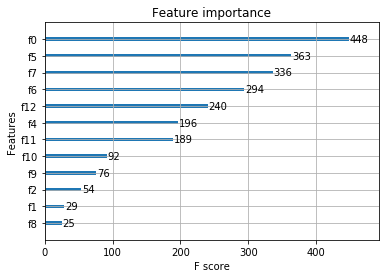

In [85]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


X,y = load_boston(return_X_y=True) # 波士顿房价
x_train, x_test, y_train, y_test = train_test_split(X, y)

model = XGBRegressor(max_depth=5, 
                         learning_rate=0.1, 
                         n_estimators=160, 
                         silent=True, 
                         objective='reg:gamma')
model.fit(x_train, y_train)

# 对测试集进行预测
y_pred = model.predict(x_test)
mse_predict = mean_squared_error(y_test, y_pred)
print(mse_predict)

# 显示重要特征
plot_importance(model)
plt.show()

In [66]:
# 调参函数
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

def modify_params(parameters):
    #param_grid = {param : param_list}
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
    model = XGBClassifier()
    grid_search = GridSearchCV(model, parameters, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(x_train,y_train)
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("mean:%f ,std:%f with: %r" % (mean, stdev, param))
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [67]:
# 选择学习率
learning_rate_param={"learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
modify_params(learning_rate_param)

mean:-0.044643 ,std:0.060176 with: {'learning_rate': 0.0001}
mean:-0.044643 ,std:0.060176 with: {'learning_rate': 0.001}
mean:-0.044643 ,std:0.060176 with: {'learning_rate': 0.01}
mean:-0.035714 ,std:0.043630 with: {'learning_rate': 0.1}
mean:-0.035714 ,std:0.043630 with: {'learning_rate': 0.2}
mean:-0.044643 ,std:0.060176 with: {'learning_rate': 0.3}
Best: -0.035714 using {'learning_rate': 0.1}


/Users/hz/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


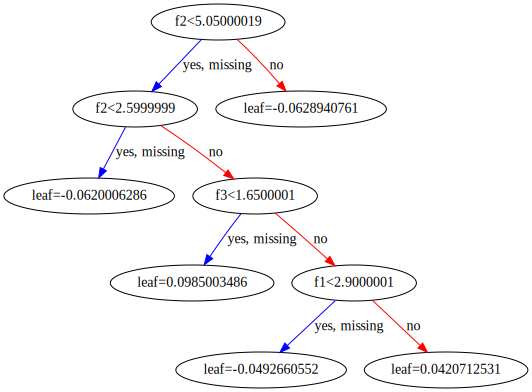

In [103]:
# 绘制决策树
xgb.to_graphviz(model, num_trees=10)